In [1]:
"""
This file is the entry point for the project
"""
# Begin by importing external libraries using path_setup
# NOTE : Must be ran first, thus PEP8-E402
import path_setup
path_setup.path_setup()
import sys  # noqa E402
import matplotlib.pyplot as plt # noqa E402
import numpy as np # noqa E402
import datetime as dt # noqa E402
from LatticeClass_F import lattice_class as lt # noqa E402
import PrintException as PE  # noqa E402
import input_funcs as inF  # noqa E402
from random import random  # noqa E402
import time
# Shebang line for interactive output in vs_code, comment this out if you have troubles running the notebook\n",
# %matplotlib widget

def rand_time() -> int:
    out = int(dt.datetime.now().strftime('%s'))
    sys.stdout.write(f"Time Seed = {out}\n")
    return(int(dt.datetime.now().strftime('%s')))

# NOTE
For some strange reason, things take longer to run in this notebook than
 in a scripting file by about a factor (values averaged over a sample of
 50 test runs using identical seeds for comparison purposes) of: 
 $$ \frac{27.22223639s}{13.68383765s} \approx 1.9893 $$
I highly recomend using the included script file named main.py in the same
 directory as this ipynb file... unless you like wasting your own time that
 is. Jupyter notebooks suck. That said, this is good to read over for the
 info included.
 
# Setup
This is the setup for the simulation.

# Parameters
## N, M
> The span of the basis vectors

## $\beta J$'s
> The temperature

# Options 0 and 1
0 for seeded random or 1 for time based
## Seeded random : 0
> seeds random with 1644121893 by default to generate a repeatable test.
## Time based : 0
> seeds radom with the current epoch time as an integer.

# TODO
It shouldnt be hard to include external magnetic field interactions

In [2]:
N = 16
M = 16
BJs = np.arange(0.1, 2, 0.05)
total_time = 1000
BJ = 0.1

size = [N, M]
lt_a = lt(1, size)
lt_b = lt(1, size, [[1, 0], [0.5, np.sqrt(3)/2]])
lt_c = lt(1, size, [[0.5, np.sqrt(3)/2], [0.5, -np.sqrt(3)/2]])
# lt_d = lt(1, size, [[0.128, np.e], [3.02398, -np.e]])

output = input('Enter 0 for seeded random or 1 for time based:')
# output = '0'
if output == '0':
    print("option 0 chosen..\n")
    # DOCtest seed = 1644121893
    seed = 1644121893
    
    lt_a.randomize(voids=True, probs=[0.25, 0.4], rand_seed=seed,
                    quiet=False)
    lt_b.randomize(voids=True, probs=[0.25, 0.4], rand_seed=seed,
                    quiet=True)
    lt_c.randomize(voids=True, probs=[0.25, 0.4], rand_seed=seed,
                   quiet=True)
#     lt_d.randomize(voids=True, probs=[0.25, 0.4], rand_seed=seed,
#                    quiet=True)

else:
    print("option 1 chosen.\n")

    lt_a.randomize(voids=True, probs=[
        random(100), random(100)],
        rand_seed=rand_time(), quiet=False)

    lt_b.randomize(voids=False, probs=[
            random(), random()],
            rand_seed=rand_time(), quiet=False)

    lt_c.randomize(voids=False, probs=[
            random(100), random(100)],
            rand_seed=rand_time(), quiet=False)

#     lt_d.randomize(voids=False, probs=[
#             random(100), random(100)],
#             rand_seed=rand_time(), quiet=False)

/home/kirisame_tempest/Programs/Ising_Model_python/src/linked_list_class.py:559: RuntimeWarning: invalid value encountered in true_divide
  temp = np.arccos((possible_neighbor-origin).dot(origin) /


 Generation complete!                                              option 0 chosen..

Generating Seed = 1644121893                                       


# Display
Calling <lattice_object>.display() will display the current spin arangement of the lattice_object.

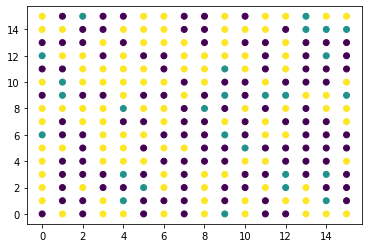

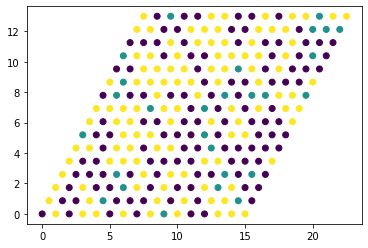

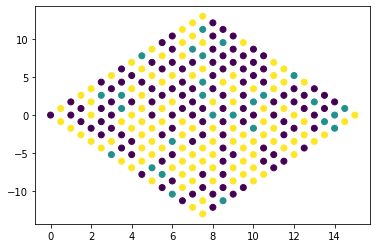

In [3]:
lt_a.display()
lt_b.display()
lt_c.display()
# lt_d.display()

# Metropolis Algorithm test
Uncomment if you want to test these. The metropolis algorithm gets ran anyways in the next section.

In [4]:
# total_time = 1000
# BJ = 1
# SE_mtx = lt_a.metropolis(total_time, BJ, quiet=False)
# plot_metrop(SE_mtx, BJ, size)
# SE_mtx = lt_b.metropolis(total_time, BJ)
# plot_metrop(SE_mtx, BJ, size)
# SE_mtx = lt_c.metropolis(total_time, BJ)
# plot_metrop(SE_mtx, BJ, size)
# SE_mtx = lt_d.metropolis(total_time, BJ)
# plot_metrop(SE_mtx, BJ, size)

# Plotting Energy-Temperature relations
Can look at $\bar{m}$ as a function of temperature:
$$ T = 1/\beta k = J/(\beta J)k $$

We can also plot heat capacity as a function of time, using:

$$C_V = \sigma_E^2 / T^2 $$

$$= (\left<E^2\right>-\left<E\right>^2) \cdot \beta^{2} k^2$$

$$= \left(\left<\left(\frac{E}{J}\right)^2\right>-\left<\frac{E}{J}\right>^2 \right) \cdot (\beta J)^{2} k^2 $$

$$= \sigma_{E/J}^2 \cdot (\beta J)^{2} k^2$$

## Whats going on
The get_spin_genery function runs the Metropolis algorithm and finds a viable equlibrium temperature for a given $\beta J$ value, plotting 38
 runs of the metropolis algorithm chained together.

Then, we use the above relations to first plot $\hat{m}$ vs $\left(\frac{k}{J}\right)T$ -- where $\hat{m}$ the Sum of Spins over the number of spins.

Again using the above relations we can also plot $C_V / k^2$ vs $\left(\frac{k}{J}\right)T$.


get_spin_energy is 100% complete in 34.17590213 seconds!           


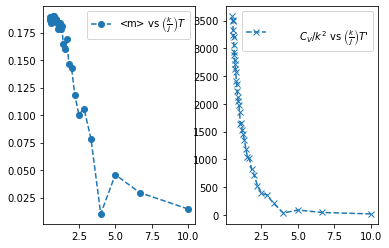

In [5]:
a, b, c = lt_a.get_spin_energy(BJs, total_time, quiet=False)

In [6]:
a, b, c = lt_b.get_spin_energy(BJs, total_time, quiet=False)


get_spin_energy is 23.7% complete...                               

KeyboardInterrupt: 

get_spin_energy is 100% complete in 33.63148427 seconds!           


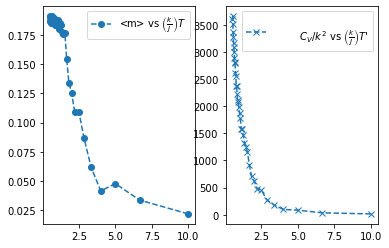

In [ ]:
a, b, c = lt_c.get_spin_energy(BJs, total_time, quiet=False)

In [ ]:
# a, b, c = lt_d.get_spin_energy(BJs, total_time, quiet=False)